In [50]:
import holidays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.plot import plot_residuals
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.direct import ForecasterDirectMultiVariate
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.model_selection import random_search_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score

# Data Loading & Feature Engineering

In [29]:
# Load the dataset from a CSV file
df = pd.read_csv("df_time_serie_2022.csv")

# Convert the 'FECHA' column to datetime format
df.FECHA = pd.to_datetime(df.FECHA)

# Set the 'FECHA' column as the index
df.set_index("FECHA", inplace=True)

Convert the wind direction into sin and cos

In [30]:
columns_with_wdr = [col for col in df.columns if 'WDR' in col]
for col in columns_with_wdr:
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / 360)
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / 360)
# Drop the original WDR columns
df.drop(columns=columns_with_wdr, inplace=True)

Exogenous variables

In [31]:
# Add day of the week
df["Dia de la semana"] = df.index.dayofweek

# Add 'Mañana' if hour < 8
df["Mañana"] = 0
df.loc[df.index.hour < 8, "Mañana"] = 1

# Add 'Tarde' if 8 <= hour < 16
df["Tarde"] = 0
df.loc[(df.index.hour >= 8) & (df.index.hour < 16), "Tarde"] = 1

# Add 'Noche' if hour >= 16
df["Noche"] = 0
df.loc[df.index.hour >= 16, "Noche"] = 1

# Add holidays from Mexico
mex_holidays = holidays.MX(years=[2022, 2023, 2024])

# Add holidays from Mexico, if it is a holiday set 'Feriado' to 1
df["Feriado"] = 0
for date in mex_holidays.keys():
    df.loc[df.index.date == date, "Feriado"] = 1

# Add non-working days in Mexico
df["Dia laboral"] = 1
df.loc[(df.index.month == 1) & (df.index.day < 6), "Dia laboral"] = 0
df.loc[(df.index.month == 4) & (df.index.day > 11) & (df.index.day < 27), "Dia laboral"] = 0
df.loc[(df.index.month == 12) & (df.index.day > 19), "Dia laboral"] = 0
df.loc[(df.index.month == 7) & (df.index.day > 16), "Dia laboral"] = 0
df.loc[(df.index.month == 8) & (df.index.day < 26), "Dia laboral"] = 0

# Create exogenous variables dataframe
exog = df[["Dia de la semana", "Mes", "Dia", "Hora", "Mañana", "Tarde", "Noche", "Feriado", "Dia laboral"]]

# Drop the columns from the main dataframe
df.drop(columns=["Dia de la semana", "Mes", "Dia", "Hora", "Mañana", "Tarde", "Noche", "Feriado", "Dia laboral"], inplace=True)

# Add day of the month
exog["Dia del mes"] = exog.index.day

# Convert categorical variables to dummy variables
exog = pd.get_dummies(exog, columns=["Dia de la semana", "Mes"])

# Convert time-related features to cyclic features
exog["hour_cos"] = np.cos(2 * np.pi * exog["Hora"] / 24)
exog["hour_sin"] = np.sin(2 * np.pi * exog["Hora"] / 24)
exog["day_cos"] = np.cos(2 * np.pi * exog["Dia del mes"] / 31)
exog["day_sin"] = np.sin(2 * np.pi * exog["Dia del mes"] / 31)
exog["Dia del año cos"] = np.cos(2 * np.pi * exog["Dia"] / 365)
exog["Dia del año sin"] = np.sin(2 * np.pi * exog["Dia"] / 365)

# Drop unnecessary columns
exog.drop(columns=["Hora", "Dia del mes", "Dia"], inplace=True)

# Ensure the dataframes have hourly frequency
df = df.asfreq("h")
exog = exog.asfreq("h")

# Convert boolean columns to integers
exog = exog.astype(int)

C:\Users\jesus\AppData\Local\Temp\ipykernel_35552\2143946489.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["Dia del mes"] = exog.index.day


In [32]:
df.index.min(), df.index.max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2024-07-31 23:00:00'))

# Split train, test, and validation set

For hyperparameter search purposes, we would want to get a validation set

In [ ]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2024-03-29 23:00:00'
end_val = '2024-07-30 23:00:00'
# Calculate the date to start the predictions automatically
start_pred = pd.to_datetime(end_val) + pd.Timedelta(hours=1)

data_train = df.loc[:end_train, :].copy()
data_val   = df.loc[end_train:end_val, :].copy()
data_test  = df.loc[end_val:, :].copy()
exog_train = exog.loc[:end_train, :].copy()
exog_val   = exog.loc[end_train:end_val, :].copy()
exog_test  = exog.loc[end_val:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

In case we already have our best hyperparameters found, we can skip the validation set and split only in train and test set

In [33]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2024-07-10 23:00:00'

# Calculate the date to start the predictions automatically
start_pred = pd.to_datetime(end_train) + pd.Timedelta(hours=1)

data_train = df.loc[:end_train, :].copy()
data_test  = df.loc[end_train:, :].copy()
exog_train = exog.loc[:end_train, :].copy()
exog_test  = exog.loc[end_train:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2022-01-01 00:00:00 --- 2024-07-10 23:00:00  (n=22128)
Test dates       : 2024-07-10 23:00:00 --- 2024-07-31 23:00:00  (n=505)


# Bayesian search to find the best hyperparameter for our model

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
modelos_pruebas = {}

# Define the search space for hyperparameters
def search_space(trial):
    search_space = {
        'lags': trial.suggest_categorical('lags', [6, 12, 14]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 70, 160),
        'max_depth': trial.suggest_int('max_depth', -1, 15),  # -1 for no limit
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    }
    return search_space

# Define the R-squared metric
def r_squared(y_true, y_pred):
    return 1 - r2_score(y_true, y_pred)

# Iterate over each PM2.5 column in the dataframe
for level in df.filter(regex=("PM2.5")).columns:
    # Initialize the forecaster
    forecaster = ForecasterDirectMultiVariate(
        regressor=LGBMRegressor(random_state=123, verbose=-1),
        level=level,  # Change level to predict
        lags=24,
        steps=6
    )
    
    # Perform Bayesian search for hyperparameters
    results, best_trial = bayesian_search_forecaster_multiseries(
        forecaster=forecaster,
        series=df,
        exog=exog,
        search_space=search_space,
        steps=6,
        metric=[r_squared, 'mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
        refit=False,
        initial_train_size=len(data_train),
        fixed_train_size=False,
        n_trials=5,
        random_state=123,
        return_best=False,
        n_jobs='auto',
        verbose=False,
        show_progress=True,
        engine='optuna',
        kwargs_create_study={},
        kwargs_study_optimize={}
    )
    
    # Store the results for each level
    modelos_pruebas[level] = results
    results.head(4)

In [ ]:
# modelos_pruebas to csv all in one csv
# ==============================================================================
for level in df.filter(regex=("PM2.5")).columns:
    modelos_pruebas[level].to_csv("modelos_pruebas.csv", mode='a', header=False)

# Model training and predict

In [ ]:
# Parameters for prediction
steps = 168
level = 'CENTRO PM2.5 (UG/M3)'
estacion = 'CENTRO PM2.5'
estacion_titulo = 'Centro'

In [35]:
# Create and fit forecaster MultiVariate
# ==============================================================================
# Define the regressor with the specified hyperparameters

regresor = LGBMRegressor(
    random_state=123, 
    verbose=-1, 
    n_estimators=145, 
    min_samples_leaf=1, 
    max_features='False', 
    learning_rate=0.19844611443148058, 
    num_leaves=29, 
    max_depth=12, 
    reg_alpha=0.6120379139339559, 
    reg_lambda=0.7732501918150064
)

# Initialize the forecaster with the defined regressor and other parameters
forecaster = ForecasterDirectMultiVariate(
    regressor=regresor,
    level= level,  # Change level to predict
    lags=6,
    steps=steps,
    transformer_series=StandardScaler(),
    transformer_exog=None,
    weight_func=None,
    n_jobs=1
)

# Fit the forecaster to the training data and exogenous variables
forecaster.fit(data_train, exog=exog_train)

In [36]:
tm = data_test.loc["2024-07-11 00:00:00":"2024-07-17 23:00:00", :]

In [40]:
# Use predict_interval to predict the next 48 hours and the confidence interval
forecaster.set_in_sample_residuals(series=data_train, exog=exog_train)
predictions = forecaster.predict_interval(steps=168, exog=exog_test.loc["2024-07-18 00:00:00":], last_window=tm)

# Results and evaluation of the prediction

In [ ]:
# Calculate evaluation metrics for the predictions
# =================================================

# Get the R^2 score
r2 = r2_score(
    data_test.filter(regex=(estacion)).loc["2024-07-18 00:00:00":].head(steps), 
    predictions.pred
)

# Get the Root Mean Squared Error (RMSE)
rmse = root_mean_squared_error(
    data_test.filter(regex=(estacion)).loc["2024-07-18 00:00:00":].head(steps), 
    predictions.pred, 
    # squared=False
)

# Get the Mean Absolute Error (MAE)
mae = mean_absolute_error(
    data_test.filter(regex=(estacion)).loc["2024-07-18 00:00:00":].head(steps), 
    predictions.pred
)

# Get the Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(
    data_test.filter(regex=(estacion)).loc["2024-07-18 00:00:00":].head(steps), 
    predictions.pred
)

# Print the evaluation metrics
print(f"R^2: {1+r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

R^2: -0.35739859647926386
RMSE: 6.872014780134826
MAE: 5.219420396709562
MAPE: 0.20436150201359332


# Plot the prediction and real data

In [54]:
predictions.columns

Index(['level', 'pred', 'lower_bound', 'upper_bound'], dtype='object')

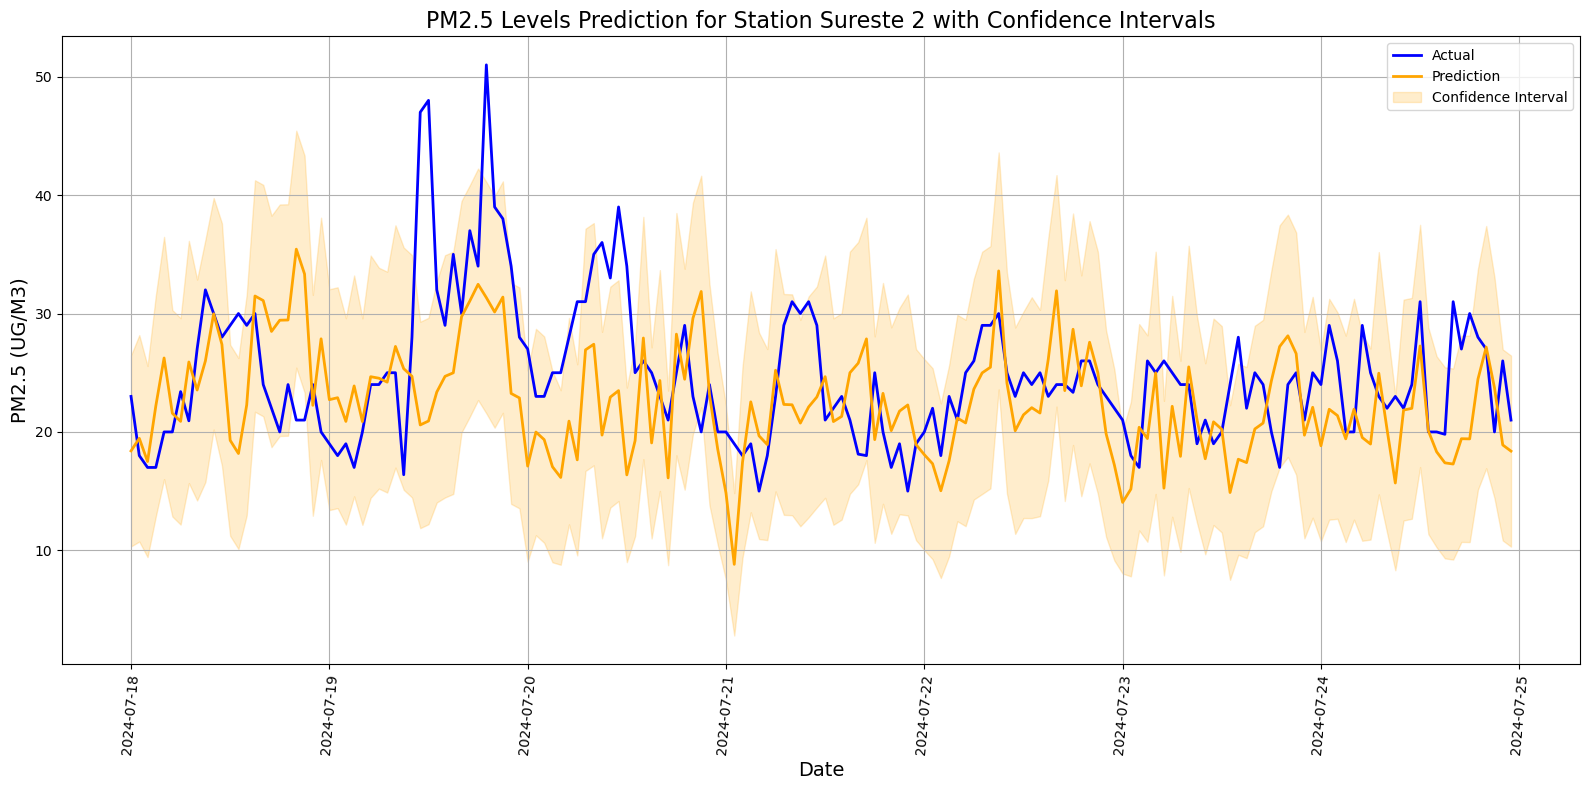

In [55]:
# Create the figure and plot the real and predicted values
plt.figure(figsize=(16,8))

# Plot real data
plt.plot(data_test.filter(regex=(estacion)).loc["2024-07-18 00:00:00":].head(steps), label="Actual", color="blue", linewidth=2)

# Plot predicted values
plt.plot(predictions['pred'].head(steps), label="Prediction", color="orange", linewidth=2)

# Add the confidence interval
plt.fill_between(
    predictions.index[:steps], 
    predictions['lower_bound'].head(steps),  # Lower bound for the confidence interval
    predictions['upper_bound'].head(steps),  # Upper bound for the confidence interval
    color='orange', alpha=0.2, label="Confidence Interval"
)

# Rotate x-axis ticks for better readability
plt.xticks(rotation=85)

# Add title and labels for better context
plt.title("PM2.5 Levels Prediction for Station " + estacion_titulo + " with Confidence Intervals", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("PM2.5 (UG/M3)", fontsize=14)

# Add grid to make it visually clear
plt.grid(True)

# Add legend to clarify the plot
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(estacion + "_" + str(start_pred)[0:10] + ".png", dpi=400)
plt.show()

# Feature Importance

In [56]:
# Get feature importances
importances = forecaster.get_feature_importances(5)
importances.head(20)

,feature,importance
708,SURESTE 2 PM2.5 (UG/M3)_lag_1,34
990,SUR SR (KW/M2)_lag_1,26
1164,NORESTE 3 WSR (KMPH)_lag_1,23
1086,NORTE 2 WSR (KMPH)_lag_1,17
204,CENTRO PM2.5 (UG/M3)_lag_1,16
540,NORTE PM2.5 (UG/M3)_lag_1,15
372,SUROESTE PM2.5 (UG/M3)_lag_1,15
498,NOROESTE 2 WSR (KMPH)_lag_1,14
1150,NORESTE 3 SO2 (PPB)_lag_5,11
1192,NORESTE WDR (DEG)_sin_lag_5,11


In [ ]:
importances.head(20).to_csv("importances_" + estacion_titulo + ".csv")